<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework-3" data-toc-modified-id="Homework-3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework 3</a></span><ul class="toc-item"><li><span><a href="#Q1" data-toc-modified-id="Q1-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Q1</a></span></li><li><span><a href="#Q2." data-toc-modified-id="Q2.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Q2.</a></span></li><li><span><a href="#Q3." data-toc-modified-id="Q3.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Q3.</a></span></li></ul></li></ul></div>

In [3]:
library(tidyverse) 
library(rethinking) 
library(lubridate) 
library(dagitty)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.4
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=native')
although this causes Stan to throw an error on a few processors.


Attaching package: 'rstan'


The following object is masked from 'package:tidyr':

    extract


Loading r

# Homework 3

<font color = 'purple'>All three problems below are based on the same data. 

* The data in data(foxes) are 116 foxes from 30 different urban groups in England. 

* These foxes are like street gangs. Group size varies from 2 to 8 individuals. 

* Each group maintains its own (almost exclusive) urban territory. 

* Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others.  </font>

<b><font color = 'purple'>We want to model the weight of each fox.  </font></b>


For the problems below, assume this DAG:

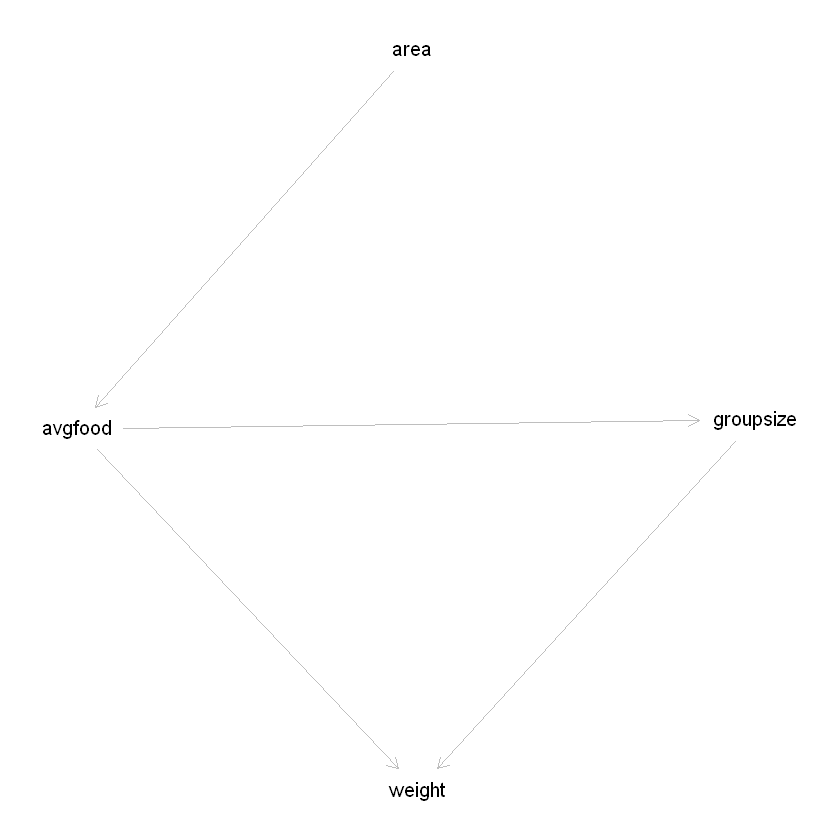

In [28]:
# DAG
fox_dag <- dagitty('dag {

bb="-2.714,-3.328,2.791,2.921"
area [pos="0.670,-1.303"]
avgfood [pos="-0.303,-0.426"]
groupsize [pos="1.662,-0.446"]
weight [pos="0.686,0.411"]

area -> avgfood
avgfood -> groupsize
avgfood -> weight
groupsize -> weight
}')

plot( fox_dag )

In [21]:
# rename foxes to f
data(foxes)
f <- foxes
f %>% head

,group,avgfood,groupsize,area,weight
,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1,0.37,2,1.09,5.02
2,1,0.37,2,1.09,2.84
3,2,0.53,2,2.05,5.33
4,2,0.53,2,2.05,6.07
5,3,0.49,2,2.12,5.85
6,3,0.49,2,2.12,3.25


## Q1

<b><font color = 'purple'>Use a model to infer the total causal influence of area on weight. 
    
* Would increasing the area available to each fox make it heavier (healthier)? 
    
    <font color = 'green'>Not really, since the bA (area) has a mean of 0 and a compatibility interval of -0.13 and 0.16. Territory size seems to have no total causal influence on weight, at least not
in this sample.</font>
    
    
* You might want to standardize the variables. 
    
* Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range. </font></b>

In [32]:
impliedConditionalIndependencies( fox_dag ) 

area _||_ grps | avgf
area _||_ wght | avgf

In [31]:
adjustmentSets( fox_dag , exposure="area" , outcome="weight" )

 {}

In [33]:
(f <- f %>%
    mutate(area_s = area %>% scale(),
          weight_s = weight %>% scale())) %>% head()

,group,avgfood,groupsize,area,weight,area_s,weight_s
,<int>,<dbl>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
1,1,0.37,2,1.09,5.02,-2.239596,0.4141347
2,1,0.37,2,1.09,2.84,-2.239596,-1.4270464
3,2,0.53,2,2.05,5.33,-1.205508,0.6759540
4,2,0.53,2,2.05,6.07,-1.205508,1.3009421
5,3,0.49,2,2.12,5.85,-1.130106,1.1151348
6,3,0.49,2,2.12,3.25,-1.130106,-1.0807692


<font color = 'blue'>Because there are no back-door paths from area to weight, we only need
to include area. No other variables are needed. Here is a model using stan-
dardized versions of the variables and those standardized priors from the
book:</font>

In [50]:
M.W_A <- quap(  alist(
    weight_s ~ dnorm( mu , sigma ) ,
    mu <- a + bA*area_s ,
    a ~ dnorm( 0 , 0.2 ) ,
    bA ~ dnorm( 0 , 0.5 ) ,
    sigma ~ dexp( 1 )
) , data = f )

In [51]:
## prior simulation
(prior <- extract.prior( M.W_A )) %>% head()

$a
   [1] -0.2299454119 -0.1368326770  0.1193950633 -0.1280629992  0.2157302594
   [6] -0.1179122744 -0.2636373083  0.0458747971 -0.1971697405 -0.0121345984
  [11] -0.1167628011  0.0880535108 -0.1038872318 -0.0946454252  0.0523193637
  [16]  0.1185689644  0.1842908305 -0.1331096600 -0.0909243481  0.0681240517
  [21]  0.0160555316  0.0317569954 -0.4913643112  0.0002753957 -0.2322444521
  [26]  0.0710975376  0.0570633976  0.0542760478  0.3037716107  0.0391906763
  [31]  0.1713715931  0.0571591058  0.4388077506 -0.1910150529  0.3026858070
  [36]  0.2249443241 -0.0489899425  0.2177102401  0.0249142139  0.2423832429
  [41] -0.0868854979  0.1306911264 -0.0580363090 -0.1210007731  0.2997822583
  [46]  0.1204064136  0.1489880633  0.0721068356 -0.2704788465  0.0527287183
  [51]  0.0644320748  0.2226520231  0.0282818232  0.1364387650  0.2643444744
  [56] -0.1371076872  0.2145352891  0.2491158724  0.3064104394 -0.4158022864
  [61] -0.3052655674  0.0947821548 -0.1483328530  0.1910762648  0.1869429554
  [66]  0.1831762860 -0.0973648336  0.1848384587 -0.4012114606  0.0529510868
  [71]  0.1759285606 -0.0419086331 -0.0235524595 -0.0620949669 -0.1634299606
  [76] -0.0830380461  0.1994380368  0.0081605554 -0.1245080145 -0.1123907303
  [81] -0.0038059099  0.0803828428 -0.2262643228 -0.5218725452  0.3998879009
  [86]  0.0723386860 -0.3172682242 -0.3718508613 -0.3188334635 -0.2458740364
  [91]  0.0694453881 -0.0471736026 -0.0761827201  0.2605160671  0.0122663994
  [96] -0.3988737666 -0.0233373006 -0.0582982491 -0.0475322447  0.1065605720
 [101]  0.1300208833  0.0950138485  0.1940988204 -0.0197306292 -0.1609064197
 [106] -0.1640237662  0.0240799929  0.0137860147 -0.0625571552 -0.1893548178
 [111]  0.0095487943 -0.2861057158 -0.2690298303 -0.0821930460  0.2377249364
 [116]  0.2646054487 -0.3683167033  0.3445642647 -0.0627468060  0.1539801998
 [121]  0.2803122454  0.0788027644  0.0280683958  0.1642366313  0.0422494895
 [126] -0.0648265236 -0.1560769642  0.1587999643  0.6175944255 -0.2941198376
 [131]  0.0518847988 -0.0230206679  0.3495289477  0.0177086809  0.1766868706
 [136] -0.1603042907 -0.0096864441  0.2146428609 -0.1644145183  0.1823397482
 [141] -0.0780384933  0.1109507745 -0.3139212837 -0.0937660733  0.0091567335
 [146]  0.2460795488  0.1120494520  0.1328706407  0.0106218180  0.1523843141
 [151] -0.1342485997 -0.0166807245  0.2776876653  0.0106233641  0.4269821337
 [156] -0.2738302715 -0.0520955193  0.2179147896  0.0960712367 -0.2440374044
 [161] -0.0440987648  0.2423735133 -0.3959601988 -0.3102935968  0.2944555449
 [166] -0.0108686360  0.0129366912  0.2023736826  0.2048393493 -0.0830003487
 [171]  0.1866621769 -0.0078224319 -0.3386284904  0.1655390875 -0.2281655668
 [176] -0.2560683837 -0.0677520646  0.1966868527 -0.5794845044  0.1516004788
 [181] -0.0212772160 -0.0834995313 -0.2609292366  0.0932957123  0.1044222734
 [186]  0.0969606461 -0.0027320649 -0.1822757970  0.1082888468  0.0801556097
 [191] -0.3010179585  0.1776938030  0.2070559347 -0.0328321617 -0.4409889956
 [196]  0.3310383588  0.2368556886  0.0344253897 -0.0547195645 -0.2434324306
 [201]  0.0915359124  0.3556294190  0.0753425868  0.0191783794  0.3925716549
 [206]  0.1985434788 -0.0612023523 -0.2736830672 -0.2248325937  0.4028756720
 [211]  0.0241128387 -0.1133540311 -0.1214398042 -0.2767749633  0.0255219609
 [216] -0.0444025207 -0.3324969000 -0.1719493572  0.0947549850 -0.1583711279
 [221] -0.3586563325  0.1417598138 -0.0243982511  0.1159433488 -0.1571583989
 [226] -0.0472653198 -0.0629767306 -0.0257397763  0.1668389173  0.1270803226
 [231]  0.0840695227  0.1490248255  0.2454882180  0.0293007360  0.2346214235
 [236] -0.0663813968  0.0592033607  0.3797076440  0.1178791211 -0.2120869686
 [241]  0.1085744644 -0.0662125457  0.2251282732  0.0810670398  0.2653268674
 [246] -0.0725945260 -0.0907861727  0.1823368604 -0.2275711156 -0.2900146445
 [251] -0.2544852155  0.4083070651 -0.4372360071  0.2799860072 -0.2263140825
 [256] -0.1373081698  0.2884124624  0.1215709618  0.1699325824  0.0612

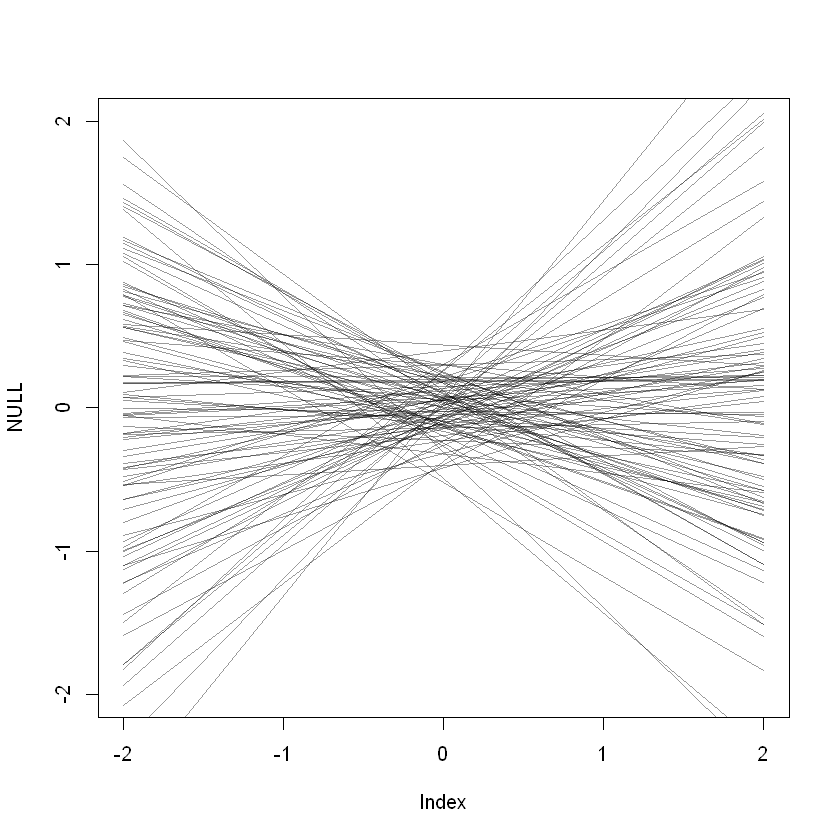

In [52]:
mu <- link( M.W_A , post=prior , data=list( area_s=c(-2,2) ) )
plot( NULL , xlim=c(-2,2) , ylim=c(-2,2) )
for ( i in 1:100 ) lines( c(-2,2) , mu[i,] , col=col.alpha("black",0.4) )

In [37]:
precis( M.W_A ) %>% round(2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.00,0.08,-0.13,0.13
bA,0.02,0.09,-0.13,0.16
sigma,0.99,0.06,0.89,1.09


## Q2.

<b><font color = 'purple'>Now infer the causal impact of adding food to a territory.  </font></b>

<b><font color = 'purple'>Would this make foxes heavier?  </font></b>

<b><font color = 'purple'>Which covariates do you need to adjust for to estimate the total causal influence of food? </font></b>

##### My attempt

In [56]:
(f <- f %>%
    mutate(avgfood_s = avgfood %>% scale())) %>% head()

,group,avgfood,groupsize,area,weight,area_s,weight_s,avgfood_s
,<int>,<dbl>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,1,0.37,2,1.09,5.02,-2.239596,0.4141347,-1.924829
2,1,0.37,2,1.09,2.84,-2.239596,-1.4270464,-1.924829
3,2,0.53,2,2.05,5.33,-1.205508,0.6759540,-1.118035
4,2,0.53,2,2.05,6.07,-1.205508,1.3009421,-1.118035
5,3,0.49,2,2.12,5.85,-1.130106,1.1151348,-1.319734
6,3,0.49,2,2.12,3.25,-1.130106,-1.0807692,-1.319734


In [99]:
impliedConditionalIndependencies( fox_dag ) 

adjustmentSets( fox_dag , exposure=c("avgfood") , outcome="weight" )

area _||_ grps | avgf
area _||_ wght | avgf

 {}

In [101]:
M.W_avgfd<- quap(  alist(
    weight_s ~ dnorm( mu , sigma ) ,
    mu <- a + bAF*avgfood_s,
    a ~ dnorm( 0 , 0.2 ) ,
    bAF ~ dnorm( 0 , 0.5 ) ,
    sigma ~ dexp( 1 )
) , data = f )

M.W_avgfd %>% precis() %>% round(2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.00,0.08,-0.13,0.13
bAF,-0.02,0.09,-0.17,0.12
sigma,0.99,0.06,0.89,1.09


In [102]:
## prior simulation
(prior <- extract.prior( M.W_avgfd )) %>% head()

$a
   [1] -0.3254876415 -0.2703884145 -0.1591642858  0.4304327885  0.1059376376
   [6]  0.0893165044 -0.0005422864 -0.2354630878  0.2970312906 -0.2290311894
  [11]  0.0906682575  0.2380053903 -0.0882890612  0.1608621593 -0.0572164056
  [16]  0.2451469071 -0.0299333428 -0.0753360270 -0.1347102552  0.2310879093
  [21] -0.1620600215  0.2227424521 -0.2604029113  0.0750062192 -0.2369575029
  [26] -0.3828574533 -0.0868831117 -0.0444676347  0.1030578430 -0.1726491828
  [31]  0.0783621397  0.0129917621  0.3381145496  0.1050504659 -0.0132552554
  [36]  0.0176205736 -0.1621130731  0.0920405612  0.0835758503  0.2730743206
  [41]  0.1236876267 -0.0756777122  0.0380735970  0.0705970262  0.0395108837
  [46]  0.0479862231 -0.0288848605 -0.0756811331 -0.0145974152 -0.2325666763
  [51]  0.2295306460 -0.2040726396 -0.1904484177 -0.2583700838 -0.4096918217
  [56]  0.1735521229  0.0441682714  0.0592724721 -0.1542547813 -0.2077440065
  [61] -0.3344318232 -0.1058878565 -0.0628743912  0.3083765481  0.3253415395
  [66] -0.1096262109 -0.0874548146 -0.0806150735 -0.1684070460  0.2419906670
  [71] -0.0382406143 -0.3095395222  0.0809415185 -0.1581093731  0.2741392131
  [76] -0.0943038923 -0.0233406392  0.2352883208  0.0617198756  0.1297601135
  [81]  0.3028718780 -0.1128997896  0.4151428696  0.3595445619  0.1534334790
  [86] -0.3637989022 -0.3428085377 -0.2138730129 -0.3098504663 -0.3054591502
  [91] -0.2304858279  0.3708077141  0.2670414412 -0.2035061992  0.0075418895
  [96]  0.2629224205  0.0122338496  0.2422471580  0.0968505708 -0.1770381297
 [101]  0.2990670166  0.1039636727  0.0511759940  0.3498403055 -0.0404566284
 [106] -0.0737296757 -0.2409480273 -0.1279020557 -0.1356859734 -0.1413117157
 [111] -0.0631984745 -0.3162169965  0.0626457393  0.4075811177 -0.0979067341
 [116]  0.2087634148 -0.3673832358  0.1003335342 -0.1949357232 -0.0610647681
 [121]  0.1290831539 -0.4233014546 -0.2455945689  0.0577090847 -0.0880095220
 [126] -0.3238345218  0.0610376329 -0.0862653195 -0.2470590710 -0.0961887891
 [131] -0.3638700675 -0.0440798995  0.3376878613  0.0869621231 -0.2592866443
 [136]  0.0830039132  0.1124919659  0.3805160820 -0.0090110771  0.0696680152
 [141] -0.0581592456 -0.0034502920 -0.2981143048 -0.2116943009 -0.0422310238
 [146]  0.0371151533  0.1316675229 -0.2281000553  0.0409947226 -0.1737633352
 [151] -0.0538033064 -0.2361827186  0.1030689712 -0.0669525985 -0.2433413953
 [156]  0.0677074031  0.2631866750  0.0053182906 -0.0852450643  0.0120760683
 [161]  0.1987349282 -0.0763418448 -0.0458234166 -0.3518955530 -0.2708524215
 [166]  0.1148956949  0.0730248124  0.1865441870 -0.2045309141  0.0436878679
 [171] -0.1014998402 -0.3945529720 -0.1048331505  0.1050930122 -0.0790520658
 [176] -0.0932290047 -0.2657755578 -0.2877545603 -0.2032063421  0.2059202484
 [181]  0.0417183626 -0.2032851282  0.2721783558 -0.4235285424  0.1559814822
 [186] -0.0581491602  0.0357399136  0.0367004776 -0.1972227820  0.2541608119
 [191]  0.0699513813 -0.1577736937 -0.1480002421  0.3601755170 -0.7638984732
 [196]  0.0535270572  0.0891571186 -0.2167015167 -0.0048964809  0.2101485702
 [201] -0.1086483539  0.1625804439  0.3248305497 -0.0449740148 -0.2730373217
 [206] -0.1048912952  0.0643784434  0.2681321373  0.0074527536  0.0193214432
 [211]  0.4238502336 -0.0300791586 -0.1541649146 -0.2107755200 -0.1802813535
 [216] -0.1345878919  0.0456474114 -0.1896435985  0.4830757444  0.0502359120
 [221] -0.2039073845  0.1050859118 -0.2893070034  0.0098620643 -0.0555163958
 [226]  0.0519314801  0.1755085971  0.1152385561  0.1806711617 -0.0226623904
 [231]  0.0672584447  0.0367487534  0.2188485908  0.0404137063  0.0709600126
 [236] -0.0749086448 -0.1220488318 -0.0943053380 -0.0048981306  0.1706470861
 [241] -0.1147178912  0.0916046235 -0.1719276414  0.2138200606  0.1896307655
 [246]  0.2487842741 -0.0962829037 -0.1540129702 -0.0392609271 -0.0004288194
 [251]  0.2013691739  0.3043187650 -0.2933493862 -0.0090497917  0.2131991160
 [256] -0.1069622783 -0.0029323815  0.0004072980 -0.0032539490  0.1175

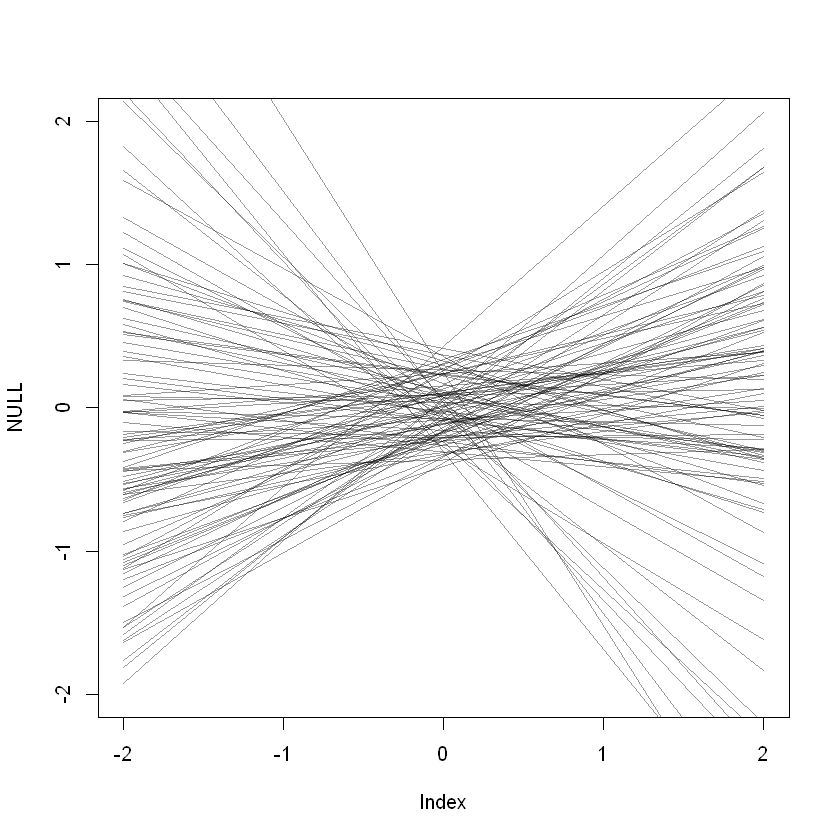

In [103]:
mu <- link( M.W_avgfd , post=prior , data=list( avgfood_s=c(-2,2) ) )
plot( NULL , xlim=c(-2,2) , ylim=c(-2,2) )
for ( i in 1:100 ) lines( c(-2,2) , mu[i,] , col=col.alpha("black",0.4) )

##### McElreath

To infer the causal influence of avgfood on weight, we need to close any
back-door paths. There are no back-door paths in the DAG. So again, just
use a model with a single predictor. If you include groupsize, to block the indirect path, then you won’t get the total causal influence of food. You’ll just get the direct influence. But I asked for the effect of adding food, and that would mean through all forward paths.

In [104]:
data(foxes)
d <- foxes
d$W <- standardize(d$weight)
d$A <- standardize(d$area)
d$F <- standardize(d$avgfood)

m2 <- quap(  alist(
    W ~ dnorm( mu , sigma ) ,
    mu <- a + bF*F ,
    a ~ dnorm( 0 , 0.2 ) ,
    bF ~ dnorm( 0 , 0.5 ) ,
    sigma ~ dexp( 1 )
) , data = d )

m2 %>% precis() %>% round(2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.00,0.08,-0.13,0.13
bF,-0.02,0.09,-0.17,0.12
sigma,0.99,0.06,0.89,1.09


Again nothing. Adding food does not change weight. This shouldn’t surprise
you, if the DAG is correct, because area is upstream of avgfood.

## Q3.

<b><font color = 'purple'>
Now infer the causal impact of group size. 

Which covariates do you need to adjust for? 
    
<br>
Looking at the posterior distribution of the resulting model, what do you think explains these data? 

That is, can you explain the estimates for all three problems? How do they go together? </font></b>

In [105]:
impliedConditionalIndependencies( fox_dag ) 

adjustmentSets( fox_dag , exposure=c("groupsize") , outcome="weight" )

area _||_ grps | avgf
area _||_ wght | avgf

{ avgfood }

In [109]:
data(foxes)
d <- foxes
d$W <- standardize(d$weight)
d$A <- standardize(d$area)
d$F <- standardize(d$avgfood)
d$G <- standardize(d$groupsize)

m3 <- quap(  alist(
    W ~ dnorm( mu , sigma ) ,
    mu <- a + bG*G + bF*F,
    a ~ dnorm( 0 , 0.2 ) ,
    bG ~ dnorm( 0 , 0.5 ) ,
    bF ~ dnorm( 0 , 0.5 ) ,
    sigma ~ dexp( 1 )
) , data = d )

m3 %>% precis() %>% round(2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.00,0.08,-0.13,0.13
bG,-0.57,0.18,-0.86,-0.29
bF,0.48,0.18,0.19,0.76
sigma,0.94,0.06,0.84,1.04


<font color = 'blue'>The variable groupsize does have a back-door path, passing through avgfood</font>. <font color = 'green'>So to infer the causal influence of groupsize, we need to close that path. This implies a model with both groupsize and avgfood as predictors.</font>

* It looks like group size is negatively associated with weight, controlling for food. Similarly, food is positively associated with weight, controlling for group size. 


* So the causal influence of group size is to reduce weight—less food for each fox. And the direct causal influence of food is positive, of course. 


* But the total causal influence of food is still nothing, since it causes larger groups. This is a masking effect, like in the milk energy example. 

<font color = 'blue'>But the causal explanation here is that more foxes move into a territory until the food available to each is no better than the food in a neighboring territory. Every territory ends up equally good/bad on average. This is known in behavioral ecology as an ideal free distribution.</font>